# Setup Environment

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import PIL
import cv2
import keras_ocr

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from keras_ocr.detection import Detector
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from PIL import Image, ImageDraw
from IPython.display import display

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

## LMDB - Lightning Memory Mapped Database
**-> key 값을 메모리에 올려두고 파일시스템에 저장된 데이터를 key값과 매핑**
얻을 수 있는 장점:  
1. 빠른 읽기와 쓰기 속도  
2. 낮은 메모리 사용량

In [2]:
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False
               )

label key's type:  <class 'bytes'>
label's type:  <class 'str'>
original image width:72, height:31
target image size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


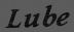

label key's type:  <class 'bytes'>
label's type:  <class 'str'>
original image width:82, height:31
target image size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


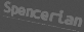

label key's type:  <class 'bytes'>
label's type:  <class 'str'>
original image width:115, height:31
target image size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


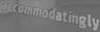

label key's type:  <class 'bytes'>
label's type:  <class 'str'>
original image width:140, height:31
target image size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


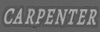

In [11]:
with env.begin(write=False) as txn:
    for index in range(1, 5):
        
        # .encode(): Convert index(string) -> byte
        label_key = 'label-%09d'.encode() % index
        # decode('~') : lmdb에서 label_key에 해당하는 값 (byte) -> string
        label = txn.get(label_key).decode('utf-8')
        print("label key's type: ",type(txn.get(label_key)))
        print("label's type: ",type(label))
        
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        
        # BytesIO() : Make buffer variable to read and write Image
        buf = six.BytesIO()
        buf.write(imgbuf)
        
        # seek(0) : To read buffer at the next iteration
        buf.seek(0)
        
        try: 
            img = Image.open(buf).convert('RGB')
        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
            
        width, height = img.size
        print(f"original image width:{width}, height:{height}")
        
        # Modify target shape : shape(w, h ->  w*32/h ,32)
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width, 32)
        print(f"target image size:{target_img_size}")
        img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)
        
        print(f"display img shape:{img.shape}")
        print(f"label:{label}")
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

# 1. Build Data pipeline

In [12]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100
        
        self.env = lmdb.open(dataset_path, 
                             max_readers=32, 
                             readonly=True, 
                             lock=False, 
                             readahead=False, 
                             meminit=False)
        
        # num_samples : Retrieve number of dataset
        # index_list : Make index list
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
            
    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        
    # Return img to array & label
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)
                
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
                
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
                    
            width, height = img.size
                
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
                
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        
        # Variables for images and labels
        # Configure input_images size as 128(BS), 100, 32, 3
        #           labels size as 128(BS), 22
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')
        
        # For CTC Loss function
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')
        
        for i, index in enumerate(batch_indicies):
            # Retrieve array type of image & label
            img, label = self._get_img_label(index)
            
            # Convert stirng type of label to intger type
            encoded_label = self.label_converter.encode(label)
            
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
            
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [13]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
                
    def encode(self, text):
        encoded_label = []
        
        for i, char in enumerate(text):
            # 연속된 문자 분리
            if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [14]:
label_converter = LabelConverter(TARGET_CHARACTERS)
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

In [41]:
# Choose a specific batch index
batch_index = 0

# Get one batch using the __getitem__ method
batch_data = train_set.__getitem__(batch_index)

# Now you can access input and output data
inputs, outputs = batch_data

# Print or inspect the data
print("Inputs:")
print("Input Image Shape:", inputs['input_image'].shape)
print("Labels Shape:", inputs['label'].shape)
print("Input Lengths:", inputs['input_length'])
print("Label Lengths:", inputs['label_length'])

print("\nOutputs:")
print("CTC Output Shape:", outputs['ctc'].shape)

Inputs:
Input Image Shape: (128, 100, 32, 3)
Labels Shape: (128, 22)
Input Lengths: [22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22]
Label Lengths: [ 4 10 17  9 13  9  5  8  8  7  6 13 10  9  5  7  5  5  7  7  5  8  8  4
  7  9  8  4  9  8  5  8  9  8  5  8  8 12  5 10  4 10  9 13  7  6 11  7
  6 10  8  6  6 12  8  8  7 14 11 12  9  8  8 10 10  8  8  9 12  7  9 10
  7  9 11 11 10  5  7  2  6  9 12  7  7  8  6  7  9  7  5  8  3  4  8  9
  8 12 11  7 12  5  4  7 11  8  6 12  4  4  7  8 10 11  3  7  6 10 12  8
  7  9 11  8 11 10  8  9]

Outputs:
CTC Output Shape: (128, 1)


# 2. Model
## 2.1 Build Model

![img1](./asset/img1.jpeg)

In [3]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [4]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Convultion Part
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # RNN part
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [5]:
model = build_crnn_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

## 2.2 Train Model 

In [14]:
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path = './model_checkpoint.hdf5'

ckp = ModelCheckpoint(filepath=checkpoint_path,
                     mointor='val_loss',
                     save_weights_only=True,
                     save_best_only=True,
                     mode='min',
                     verbose=1)

es = EarlyStopping(monitor='val_loss',
                  patience=5,
                  verbose=1,
                  restore_best_weights=True)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp,es]
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
565/565 [==============================] - 92s 153ms/step - loss: 15.5622 - val_loss: 10.8330

Epoch 00001: val_loss improved from inf to 10.83297, saving model to ./model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 84s 149ms/step - loss: 7.6667 - val_loss: 6.8743

Epoch 00002: val_loss improved from 10.83297 to 6.87431, saving model to ./model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 84s 149ms/step - loss: 5.4816 - val_loss: 5.5858

Epoch 00003: val_loss improved from 6.87431 to 5.58584, saving model to ./model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 85s 150ms/step - loss: 4.3340 - val_loss: 4.9661

Epoch 00004: val_loss improved from 5.58584 to 4.96606, saving model to ./model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 85s 150ms/step - loss: 3.5705 - val_loss: 4.4386

Epoch 00005: val_loss improved from 4.96606 to 4.43858, saving model to ./model_checkpoint.hdf5


## 2.3 Inference
**Points We shoul focus**
 - model output: result of cfc algorithm
 - To Visualize the model result, we should configure the new model based on trained model

### 2.3.1 Check the model output
-> The mean of 'model_output' value is same as loss value of epoch 6

In [42]:
model_output = model.predict(val_set)

In [44]:
print(np.mean(model_output))

4.231774


### 2.3.2 Visualize

In [48]:
# Build the model for visualization
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 ['SLINKING']


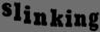

Result: 	 ['ALEP-PO']


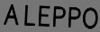

Result: 	 ['IWENDE']


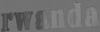

Result: 	 ['NATHANS']


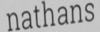

Result: 	 ['HALED']


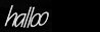

Result: 	 ['HURLS']


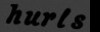

Result: 	 ['DOWNSIZE']


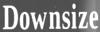

Result: 	 ['ROBOTIC']


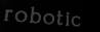

Result: 	 ['STOP-PY']


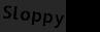

Result: 	 ['HERMITE']


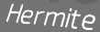

In [29]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, 
                             label_converter, 
                             batch_size=BATCH_SIZE, 
                             character=TARGET_CHARACTERS)

def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""

    for index in indexes:
        if index != -1:
            text += chars[index]
    results.append(text)
    return results

def check_inference(model, dataset, index=5):
    for i in range(index):
        img = dataset[i][0]['input_image'][0:1, :, :, :]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)
        print("Result: \t", result)

        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)


(1, 24)
37
[[37 19 19 37 12 37  9  9 37 14 14 37 37 37 11 37  9  9 37 14 14 37 37  7]]
Text: 	 *SS*L*II*NN***K*II*NN**G
Result: 	 ['*SS*L*II*NN***K*II*NN**G']


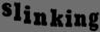

(1, 24)
37
[[37 37  1 37 37 37 37 12 37 37 37  5 37 37 16 37  0 37 16 37 37 37 15 37]]
Text: 	 **A****L***E**P*-*P***O*
Result: 	 ['**A****L***E**P*-*P***O*']


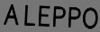

(1, 24)
37
[[37 37  9 37 37 23 37 37 37 37  5 37 37 37 14 37 37 37  4 37 37 37  5 37]]
Text: 	 **I**W****E***N***D***E*
Result: 	 ['**I**W****E***N***D***E*']


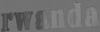

(1, 24)
37
[[37 37 37 14 37 37  1 37 37 20 37  8  8 37 37  1 37 37 14 14 37 37 19 19]]
Text: 	 ***N**A**T*HH**A**NN**SS
Result: 	 ['***N**A**T*HH**A**NN**SS']


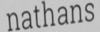

(1, 24)
37
[[37 37  8  8 37  1 12 12 12  5  4 37 37 37 37 37 37 37 37 37 37 37 37 37]]
Text: 	 **HH*ALLLED*************
Result: 	 ['**HH*ALLLED*************']


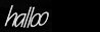

(1, 24)
37
[[37 37 37  8 37 37 37 21 37 37 37 37 18 37 37 37 37 37 37 19 19 37 37 37]]
Text: 	 ***H***U****R******SS***
Result: 	 ['***H***U****R******SS***']


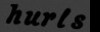

(1, 24)
37
[[37 37  4 37 37 15 15 37 37 23 37 37 37 14 37 37 19 37  9 37 26 26 37  5]]
Text: 	 **D**OO**W***N**S*I*ZZ*E
Result: 	 ['**D**OO**W***N**S*I*ZZ*E']


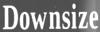

(1, 24)
37
[[37 37 18 37 37 15 37 37  2 37 37 37 15 37 20 20  9  9 37  3 37 37 37 37]]
Text: 	 **R**O**B***O*TTII*C****
Result: 	 ['**R**O**B***O*TTII*C****']


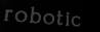

(1, 24)
37
[[37 19 19 37 20 37 15 37 37 16  0 16 37 37 25 25 37 37 37 37 37 37 37 37]]
Text: 	 *SS*T*O**P-P**YY********
Result: 	 ['*SS*T*O**P-P**YY********']


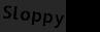

(1, 24)
37
[[37 37 37  8 37 37  5 37 37 18 18 37 37 37 13 37  9  9 20 20 37 37  5 37]]
Text: 	 ***H**E**RR***M*IITT**E*
Result: 	 ['***H**E**RR***M*IITT**E*']


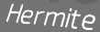

In [41]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, 
                             label_converter, 
                             batch_size=BATCH_SIZE, 
                             character=TARGET_CHARACTERS)

def decode_output(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = np.argmax(out, axis=-1)
    text = ""
    print(indexes.shape)
    print(len(chars))
    print(indexes)
    for index in indexes[0]:
        if index != len(chars):  # Assuming len(chars) is the index for the blank character
            text += chars[index]
        elif index == len(chars):
            text += '*'
    results.append(text)
    return text, results

def check_inference(model, dataset, index=5):
    for i in range(index):
        img = dataset[i][0]['input_image'][0:1, :, :, :]
        output = model.predict(img)
        text, result = decode_output(output, chars="-" + TARGET_CHARACTERS)
        print("Text: \t", text)
        print("Result: \t", result)

        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)


# 3. End to End model

In [8]:
checkpoint_path = './model_checkpoint.hdf5'
model = build_crnn_model()
model.load_weights(checkpoint_path)

# https://keras-ocr.readthedocs.io/en/latest/api.html
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [6]:
def detect_text(img_path):
    img_pil = Image.open(img_path)
    
    # img_draw : To Draw Red Box on the image
    img_draw = ImageDraw.Draw(img_pil)
    
    img_array = np.array(img_pil)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Slice for first batch -> Focus on Only one image for test
    ocr_result = detector.detect(img_array)[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))
        
    return img_pil, cropped_imgs

In [7]:
def recognize_img(pil_img, input_img_size=(100,32)):
    img_resize = pil_img.resize(input_img_size)
    img = np.array(img_resize).transpose(1,0,2)
    img = np.expand_dims(img, axis=0)
    
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

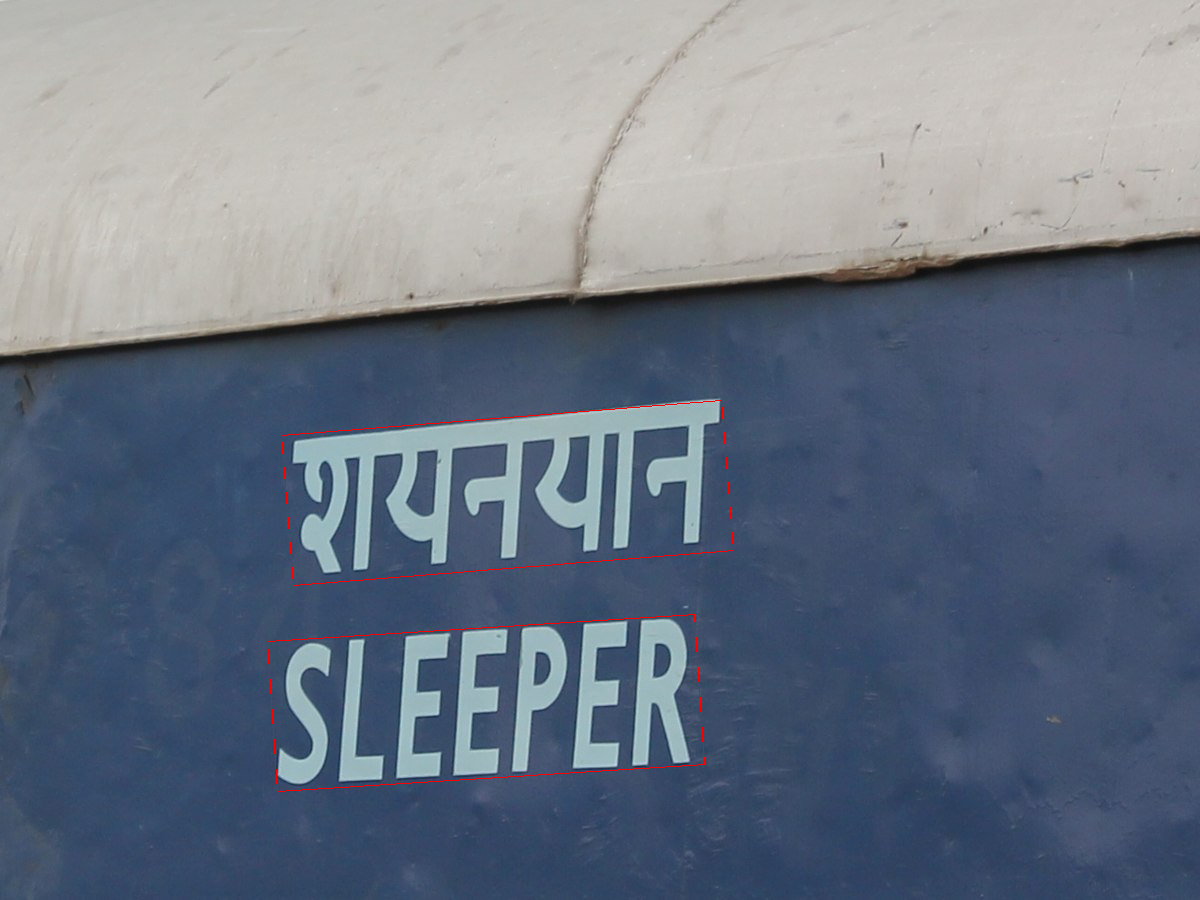

NameError: name 'decode_predict_ctc' is not defined

In [9]:
model = build_crnn_model()
model.load_weights(checkpoint_path)

# Configure the New Model
# Input : model.get_layer('input_image').output
# Output: model.get_layer('output')
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

for _img in cropped_img:
    recognize_img(_img)

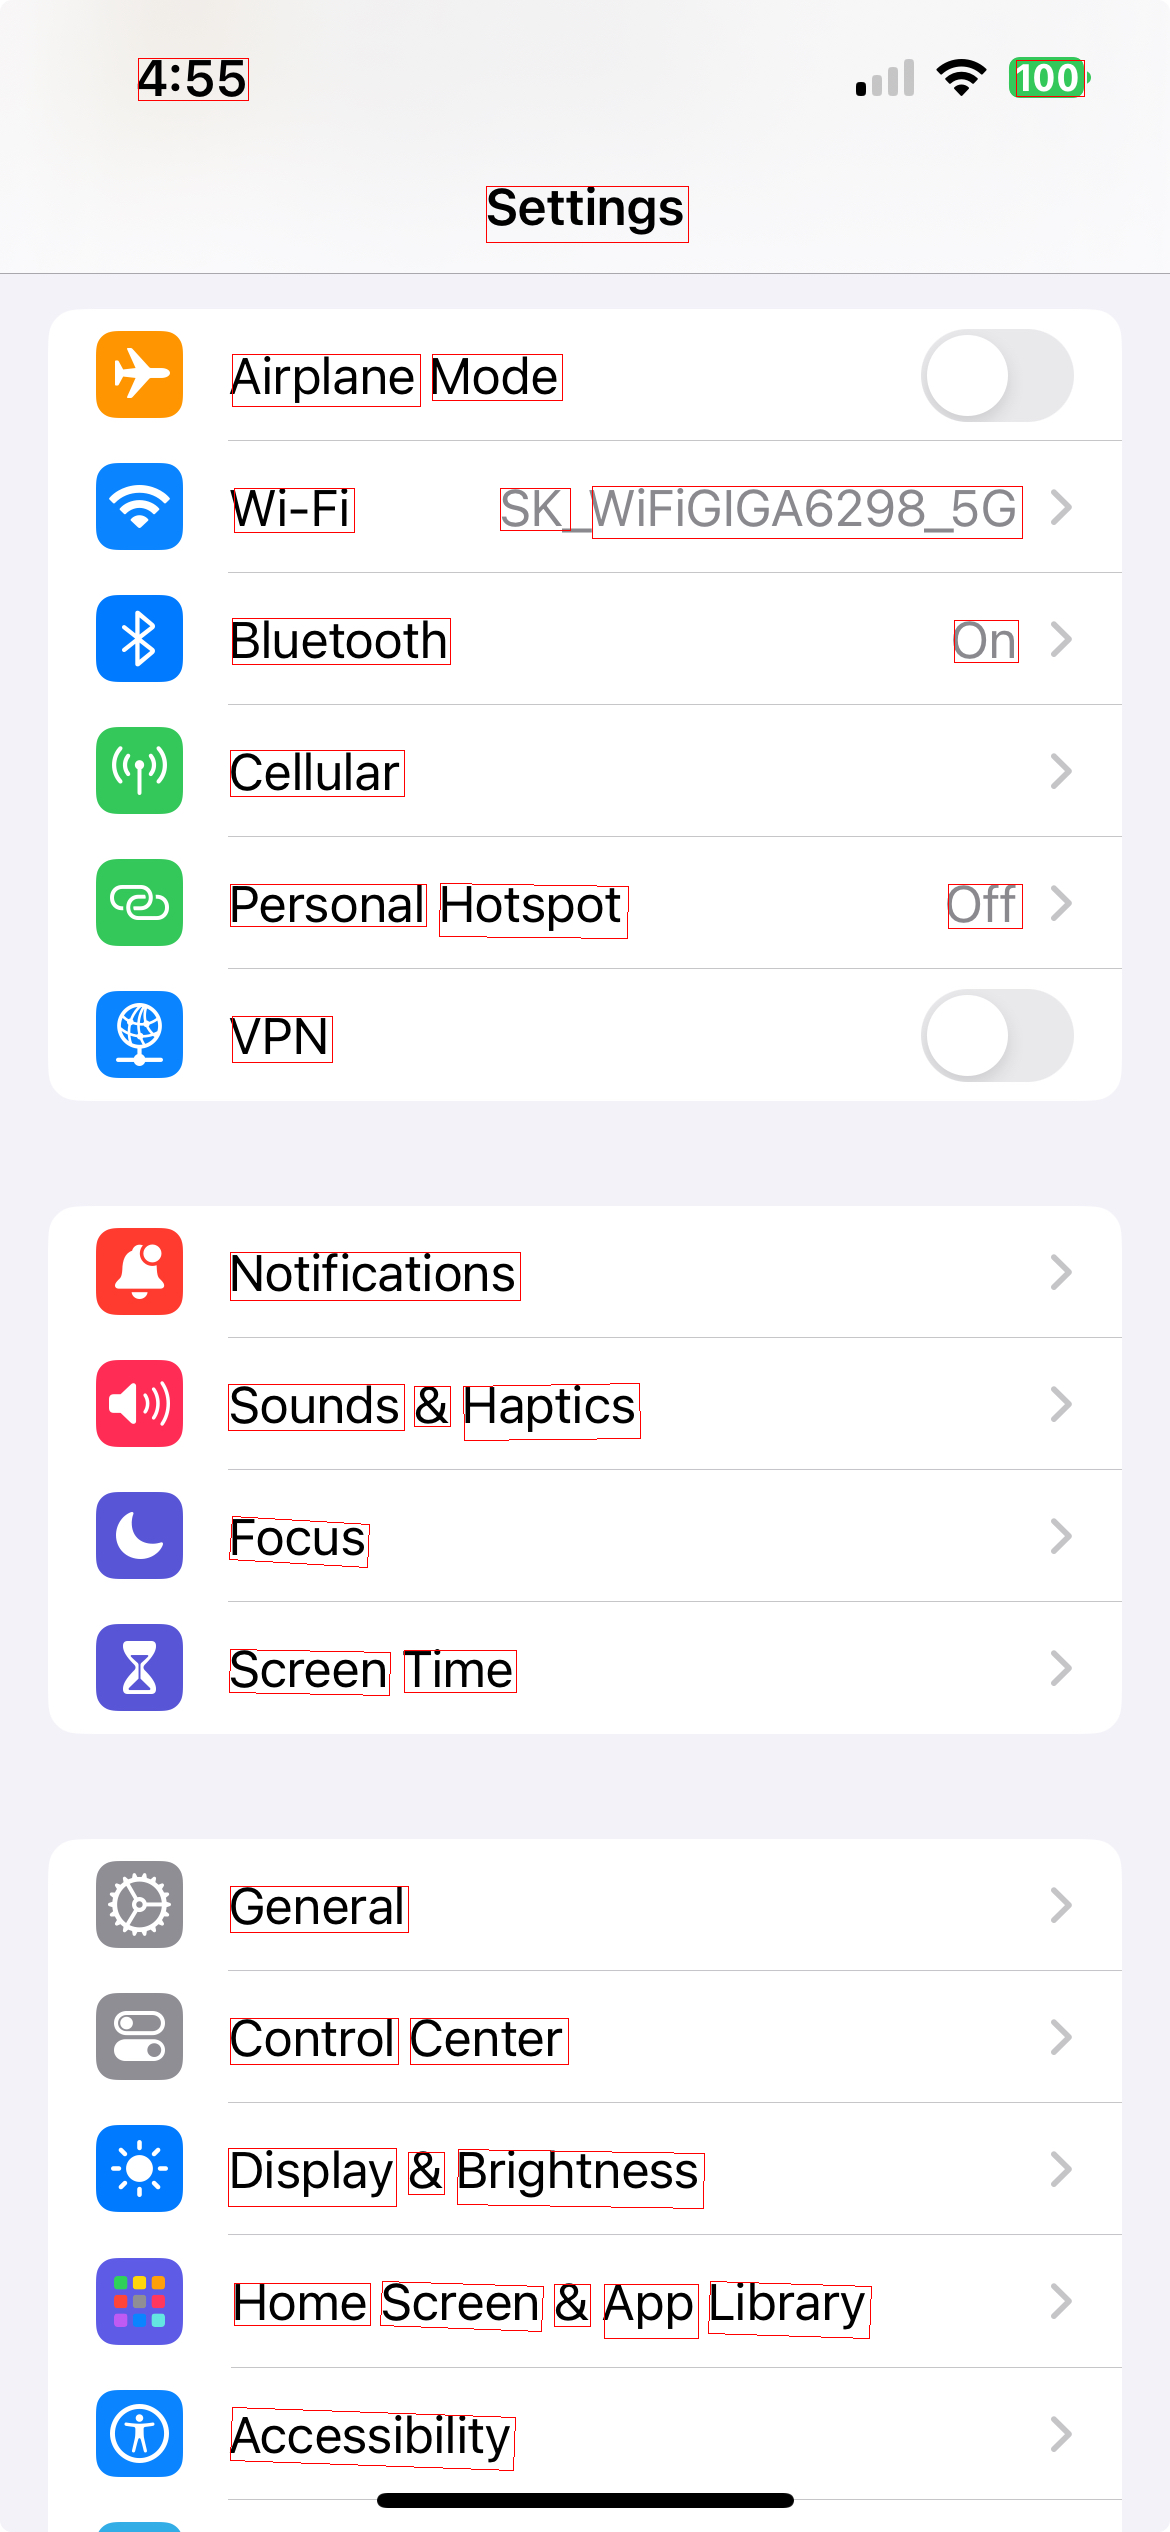

Result: 	 ZES


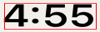

Result: 	 XCA


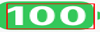

Result: 	 SETTINGS


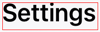

Result: 	 AIRPLANE


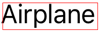

Result: 	 MODEI


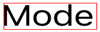

Result: 	 IFIGATIONEG


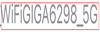

Result: 	 VIHFIN


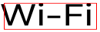

Result: 	 S


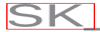

Result: 	 BLUETOOTH


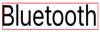

Result: 	 DRY


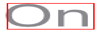

Result: 	 CELLULAR


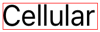

Result: 	 PERSONAL


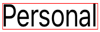

Result: 	 HOTSPOT


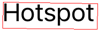

Result: 	 OFF


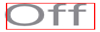

Result: 	 MPNI


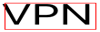

Result: 	 INOTIFICATIONS


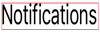

Result: 	 SOUNDS


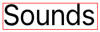

Result: 	 HAPTICS


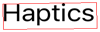

Result: 	 AZT


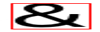

Result: 	 FOCUS


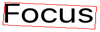

Result: 	 SCREEN


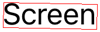

Result: 	 TINNEI


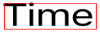

Result: 	 GENERAL


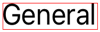

Result: 	 CONTROL


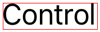

Result: 	 CENTER


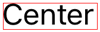

Result: 	 DISPLAY


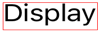

Result: 	 BRIGHTNESS


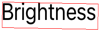

Result: 	 AZY


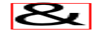

Result: 	 SCREEN


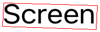

Result: 	 HONE


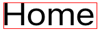

Result: 	 AZY


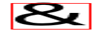

Result: 	 DOY


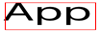

Result: 	 LIBRARY


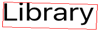

Result: 	 ACCESSIBILITY


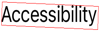

In [62]:
SAMPLE_IMG_PATH_2 ='./asset/img2.jpeg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH_2)
display(img_pil)

for _img in cropped_img:
    recognize_img(_img)

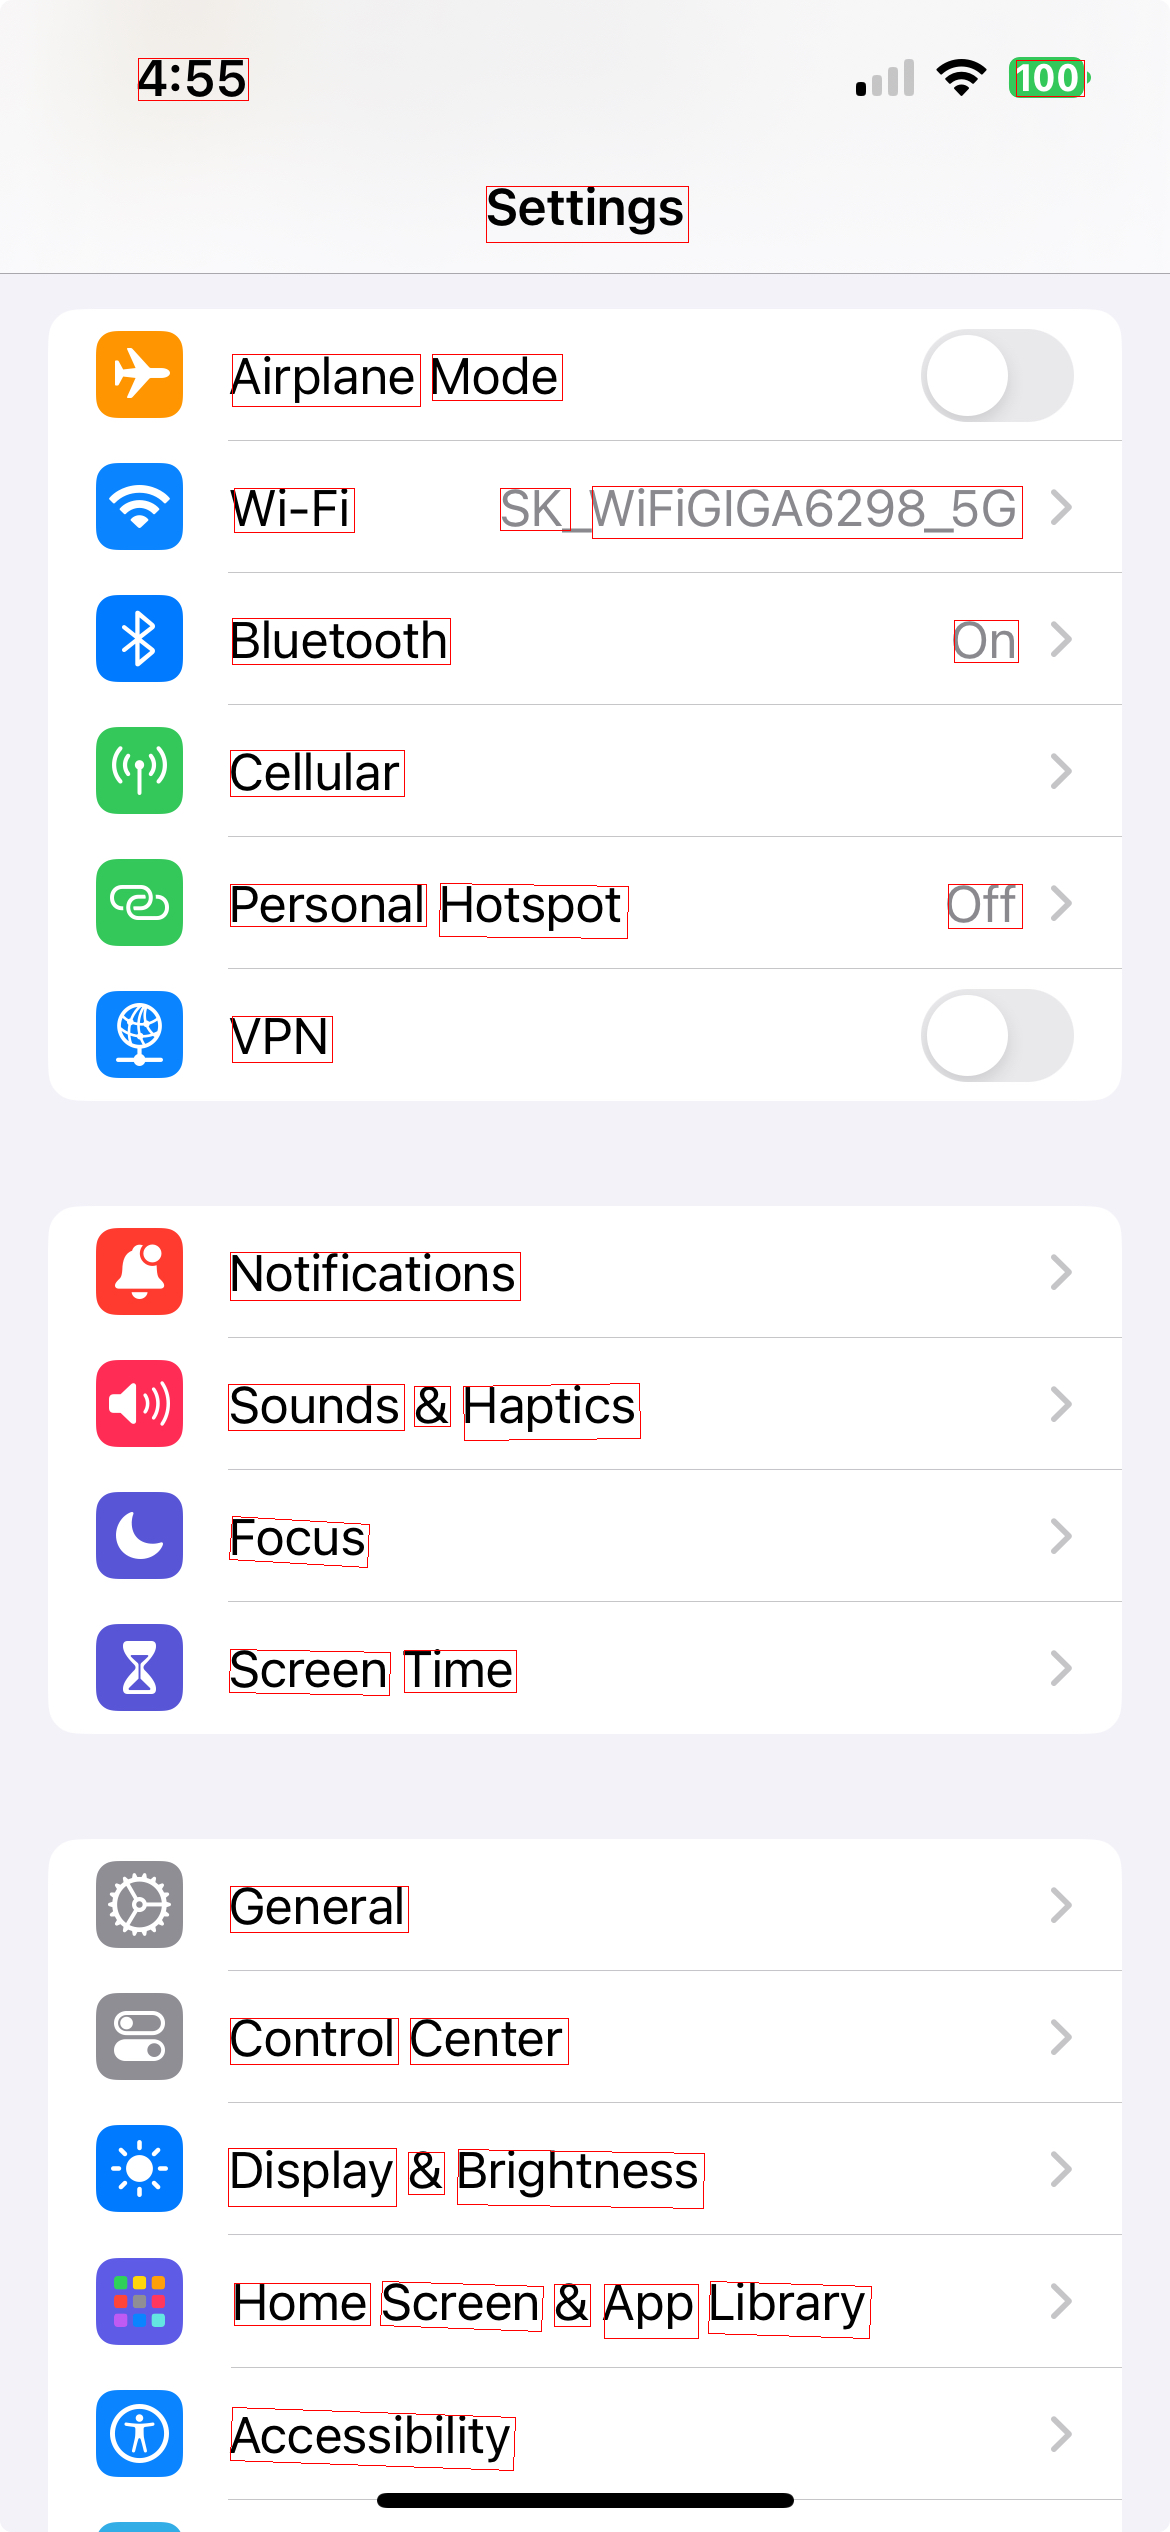

Result: 	 ZLS


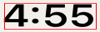

Result: 	 SKOR


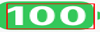

Result: 	 SETTINGS


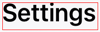

Result: 	 AIRPLANE


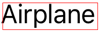

Result: 	 MODES


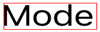

Result: 	 VIFCIGAOIBRIE


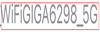

Result: 	 WIEFI


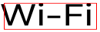

Result: 	 ISI


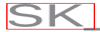

Result: 	 BLUETOOTH


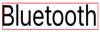

Result: 	 IDNS


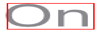

Result: 	 CELULAR


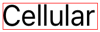

Result: 	 PERSONAL


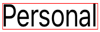

Result: 	 HOTSPOT


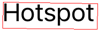

Result: 	 ROFTF


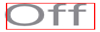

Result: 	 PNI


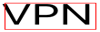

Result: 	 NOTIFICATIONS


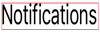

Result: 	 SOUNDS


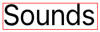

Result: 	 HAPTICS


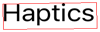

Result: 	 SRI


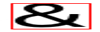

Result: 	 FOCUS


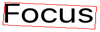

Result: 	 SCREEN


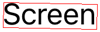

Result: 	 TIMEI


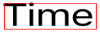

Result: 	 GENERAL


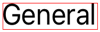

Result: 	 CONTROL


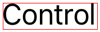

Result: 	 CENTER


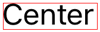

Result: 	 DISPLAY


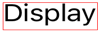

Result: 	 BRIGHTNESS


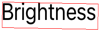

Result: 	 SESZS


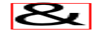

Result: 	 SCREN


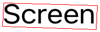

Result: 	 HOMES


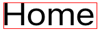

Result: 	 SESZS


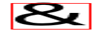

Result: 	 JAP


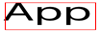

Result: 	 LIBRARY


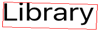

Result: 	 ACCESSILBILITY


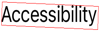

In [63]:
checkpoint_path = '/aiffel/data/model_checkpoint.hdf5'

model = build_crnn_model()
model.load_weights(checkpoint_path)

# Configure the New Model
# Input : model.get_layer('input_image').output
# Output: model.get_layer('output')
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH_2)
display(img_pil)

for _img in cropped_img:
    recognize_img(_img)

# Wrap up & Retrospective
- CTC 최대 지점 알고리즘 이해 못했다.  

## 참고자료

![img1](./asset/img5.jpeg)
![img1](./asset/img3.jpeg)
![img1](./asset/img4.jpeg)